In [1]:
import sys

import numpy as np
from scipy.fft import dct

from matplotlib import pyplot as plt, colors, cm, scale as mscale
from matplotlib.collections import LineCollection
import cmasher

from tqdm import tqdm

sys.path.append('..')
from sketched.sketched import DiscreteSpectrum, SketchedEquivalence, JointSketchingEquivalence

In [2]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{bm}')
plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 'small'
plt.rcParams['axes.titlepad'] = 3
plt.rcParams['xtick.labelsize'] = 'x-small'
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['patch.linewidth'] = 0.7
plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.6
plt.rcParams['grid.linewidth'] = 0.6
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.width'] = 0.4
plt.rcParams['ytick.major.width'] = plt.rcParams['xtick.major.width']
plt.rcParams['ytick.minor.width'] = plt.rcParams['xtick.minor.width']

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

1.6329931618554339


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.67it/s]


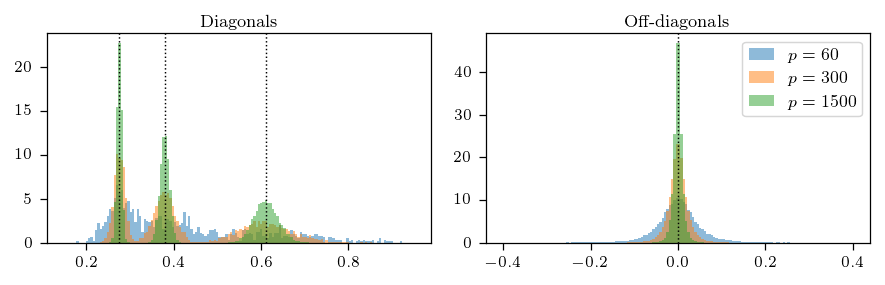

In [3]:
def scaled_up_and_sketched_resolvent(a, k=1, alpha = 0.5, lamda = 1.0):
    
    a = np.repeat(a, k)
    p = len(a)
    
    A = np.diag(a)
    
    q = int(alpha * p)
    S = np.random.randn(p, q) / np.sqrt(q)
    
    return S @ np.linalg.solve(S.T @ A @ S + lamda * np.eye(q), S.T)

def get_diags_and_off_diags(A):
    
    off_diag_mask = np.logical_not(np.eye(A.shape[0], dtype=bool))
    
    return np.diag(A), A[off_diag_mask]

a = np.asarray([0, 1, 2])
alpha = 0.8
lamda = 1
ks = [20, 100, 500]
n_trials = 20
n_bins = 150
diag_bins = np.linspace(0.15, 0.95, n_bins + 1)
diag_span = max(diag_bins) - min(diag_bins)
offdiag_bins = np.linspace(-diag_span / 2, diag_span / 2, n_bins + 1)

np.random.seed(0)

se = SketchedEquivalence(DiscreteSpectrum(a), alpha)
mu = se.get_mu_from_lamda(lamda)
print(mu)

for i, k in enumerate(ks):
    
    diags = np.array([])
    off_diags = np.array([])
    
    for _ in tqdm(range(n_trials)):
        sketch = scaled_up_and_sketched_resolvent(a, k, alpha, lamda)
        d, od = get_diags_and_off_diags(sketch)
        diags = np.concatenate([diags, d])
        off_diags = np.concatenate([off_diags, od])
    
    plt.subplot(1, 2, 1)
    plt.hist(diags, diag_bins, density=True, alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.hist(off_diags, offdiag_bins, density=True, alpha=0.5, label=f'$p={k * len(a)}$')

plt.subplot(1, 2, 1)
ylim = plt.ylim()
for x in a:
    plt.plot(1 / (np.asarray([x, x]) + mu), ylim, ':k')
plt.ylim(ylim)
plt.title('Diagonals')

plt.subplot(1, 2, 2)
ylim = plt.ylim()
plt.plot([0, 0], ylim, ':k')
plt.ylim(ylim)
plt.legend()
plt.title('Off-diagonals')

plt.tight_layout()
plt.savefig('empirical_concentration.pdf', bbox_inches='tight')
plt.show()

1.6329931618554339 0.8125669139059257 0.4039216464579655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.12it/s]


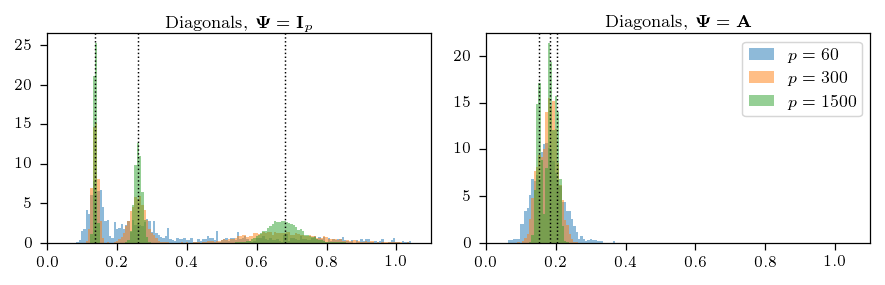

In [4]:
np.random.seed(0)
diag_bins = np.linspace(0.05, 1.05, n_bins + 1)

se = SketchedEquivalence(DiscreteSpectrum(a), alpha)
mu = se.get_mu_from_lamda(lamda)
mu_prime_I = se.get_mu_prime(DiscreteSpectrum(np.ones_like(a)), lamda=lamda)
mu_prime_A = se.get_mu_prime(DiscreteSpectrum(a), lamda=lamda)
print(mu, mu_prime_I, mu_prime_A)

for i, k in enumerate(ks):
    
    diags_I = np.array([])
    diags_A = np.array([])
    
    for _ in tqdm(range(n_trials)):
        sketch = scaled_up_and_sketched_resolvent(a, k, alpha, lamda)
        
        d, _ = get_diags_and_off_diags(sketch @ sketch)
        diags_I = np.concatenate([diags_I, d])
        
        d, _ = get_diags_and_off_diags((sketch * np.repeat(a, k)[None, :]) @ sketch)
        diags_A = np.concatenate([diags_A, d])
    
    plt.subplot(1, 2, 1)
    plt.hist(diags_I, diag_bins, density=True, alpha=0.5)
    
    plt.subplot(1, 2, 2)
    plt.hist(diags_A, diag_bins, density=True, alpha=0.5, label=f'$p={k * len(a)}$')

plt.subplot(1, 2, 1)
ylim = plt.ylim()
for x in a:
    plt.plot((1 + mu_prime_I) / (np.asarray([x, x]) + mu) ** 2, ylim, ':k')
plt.ylim(ylim)
plt.title(r'Diagonals, ${\bm \Psi} = \mathbf{I}_p$')

plt.subplot(1, 2, 2)
ylim = plt.ylim()
for x in a:
    plt.plot((np.asarray([x, x]) + mu_prime_A) / (np.asarray([x, x]) + mu) ** 2, ylim, ':k')
plt.ylim(ylim)
plt.legend()
plt.title(r'Diagonals, ${\bm \Psi} = \mathbf{A}$')

plt.tight_layout()
plt.savefig('empirical_concentration_second.pdf', bbox_inches='tight')
plt.show()